This kernel generates BEV (Bird's Eye View) images for the test data set. We will be feeding these image into NN for test set predictions. Instead of processing all the images everytime we want to make a prediction, it's better to generate it once and reuse it.

You can find Guido Zuidof's [original kernel](https://www.kaggle.com/gzuidhof/reference-model) here.

In [1]:
!pip install lyft-dataset-sdk -q

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
from lyft_dataset_sdk.lyftdataset import LyftDataset

In [2]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R
from pathlib import Path

from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
import time
from lyft_dataset_sdk.utils.map_mask import MapMask

In [5]:
!unlink images
!unlink maps
!unlink lidar

!ln -s ../input/3d-object-detection-for-autonomous-vehicles/test_images images
!ln -s ../input/3d-object-detection-for-autonomous-vehicles/test_maps maps
!ln -s ../input/3d-object-detection-for-autonomous-vehicles/test_lidar lidar

In [6]:
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        # Initialize map mask for each map record.
        for map_record in self.map:
            map_record["mask"] = MapMask(self.data_path / map_record["filename"], resolution=map_resolution)

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        # Add reverse indices from log records to map records.
        if "log_tokens" not in self.map[0].keys():
            raise Exception("Error: log_tokens not in map table. This code is not compatible with the teaser dataset.")
        log_to_map = dict()
        for map_record in self.map:
            for log_token in map_record["log_tokens"]:
                log_to_map[log_token] = map_record["token"]
        for log_record in self.log:
            log_record["map_token"] = log_to_map[log_record["token"]]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

In [7]:
level5data = LyftTestDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/test_data', verbose=True)
# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
ARTIFACTS_FOLDER = "./artifacts"
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

9 category,
17 attribute,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
1 map,
Done loading in 1.8 seconds.
Reverse indexing ...
Done reverse indexing in 0.6 seconds.


In [8]:
sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
sample_sub.head()

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,NaN
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,NaN
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,NaN
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,NaN
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,NaN


As input for our network we voxelize the LIDAR points. That means that we go from a list of coordinates of points, to a X by Y by Z space.

In [9]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

In [10]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

Above is an example of what the input for our network will look like. It's a top-down projection of the world around the car (the car faces to the right in the image). The height of the lidar points are separated into three bins, which visualized like this these are the RGB channels of the image.

In [11]:
bev_shape = (336, 336, 3)
target_im = np.zeros(bev_shape, dtype=np.uint8)

def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

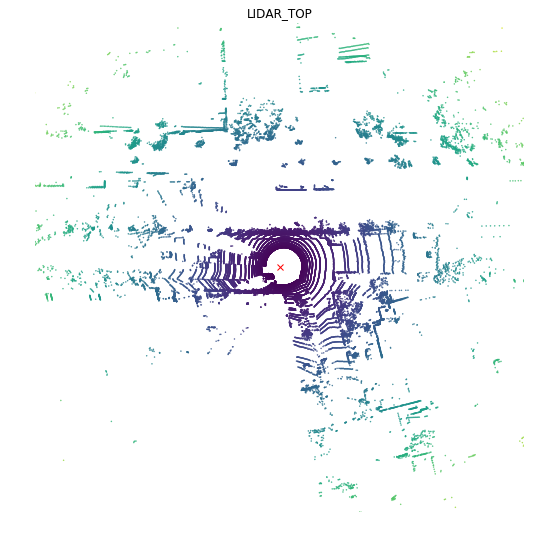

In [12]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
    
# Don't worry about it being mirrored.
visualize_lidar_of_sample(sample_sub.loc[0,'Id'])

In [16]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

NUM_WORKERS = os.cpu_count() * 3

# "bev" stands for birds eye view
# test_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_test_data")
test_data_folder = '/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/bev_test_data'

In [24]:
def prepare_testing_data_for_scene(sample_token, level5data, output_folder=test_data_folder,
                                   bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset,
                                   box_scale=box_scale):
    """
    Given a sample token (in a scene), output rasterized input volumes in birds-eye-view perspective.

    """
    
#     while sample_token:
        
    sample = level5data.get("sample", sample_token)
    

    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    
    

    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])
    


    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)
    

    car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                        inverse=False)
    
    
    lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
    
    lidar_pointcloud.transform(car_from_sensor)

    bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
    bev = normalize_voxel_intensities(bev)

    bev_im = np.round(bev*255).astype(np.uint8)

    cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)

In [18]:
# # to debug..
# # doesn't work right now
# os.makedirs(test_data_folder, exist_ok=True)
# # NUM_WORKERS = 4
# pool = Pool(NUM_WORKERS)
# for _ in tqdm_notebook(pool.imap(partial(prepare_testing_data_for_scene,
#                        output_folder=test_data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale),sample_sub.loc[:,'Id'].values)
#                       ,total=len(sample_sub)):
#     pass

# pool.close()
# del pool

In [19]:
for token in tqdm_notebook(sample_sub.loc[:,'Id'].values):
    prepare_testing_data_for_scene(token)

In [20]:
train = pd.read_csv("../input/3d-object-detection-for-autonomous-vehicles/train.csv")

In [29]:
level5data_train = LyftDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 8.0 seconds.
Reverse indexing ...
Done reverse indexing in 2.1 seconds.


In [30]:
!unlink images
!unlink maps
!unlink lidar

!ln -s ../input/3d-object-detection-for-autonomous-vehicles/train_images images
!ln -s ../input/3d-object-detection-for-autonomous-vehicles/train_maps maps
!ln -s ../input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar

In [40]:
def prepare_training_data_for_scene(first_sample_token, level5data, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        
        sample_token = sample["next"]

In [31]:
from functools import partial
import glob
from multiprocessing import Pool

In [38]:
records = [(level5data_train.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data_train.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data_train.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [41]:
first_samples = df.first_sample_token.values

process_func = partial(prepare_training_data_for_scene,
                       level5data = level5data_train,
                       output_folder='/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/bev_train_data',\
                       bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

pool = Pool(NUM_WORKERS)
for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
    pass
pool.close()
del pool

Process ForkPoolWorker-113:
Process ForkPoolWorker-111:
Process ForkPoolWorker-110:
Process ForkPoolWorker-117:
Process ForkPoolWorker-116:
Process ForkPoolWorker-119:
Process ForkPoolWorker-114:
Process ForkPoolWorker-115:
Process ForkPoolWorker-118:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-112:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-82:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run(

KeyboardInterrupt: 

KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
Process ForkPoolWorker-96:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-105:
Traceback (most recent call last):
Process ForkPoolWorker-93:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
Process ForkPoolWorker-104:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-90:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessi

In [ ]:
!tar -czf lyft3d_bev_test_data.tar.gz ./artifacts/ 

In [ ]:
!du -h lyft3d_bev_test_data.tar.gz

In [ ]:
!rm -r ./artifacts